In [103]:
#%%
%matplotlib inline
import pandas as pd
import plotly.plotly as py
import ast
import geopandas as gpd
import urllib2
from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
import seaborn as sns
min_max_scaler = preprocessing.MinMaxScaler()

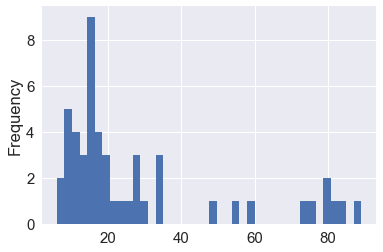

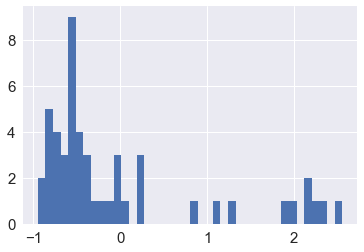

In [104]:
seleCol =  range(40,45)
seleCol.append(1)

####  read law scores
laws = pd.read_csv('laws.csv', delimiter=' ', header=None, usecols=seleCol)
laws.columns = ['state', 'total_score','curved_score','grade','2010_gun_death_rate','2009_gun_export_rates']
laws.set_index('state', inplace = True)
#laws.to_csv('laws_filter.csv')
laws = pd.read_csv('laws_filter.csv', delimiter=',')
laws.sort_values(laws.columns[0], ascending = True, inplace = True)
laws.reset_index(drop=True, inplace = True)
#read state code
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')
laws['code']=df['code']
laws = laws[['code','state','curved_score']]

#sklearn.preprocessing.robust_scale(X, axis=0, with_centering=True, \
#with_scaling=True, quantile_range=(25.0, 75.0), copy=True)[source]¶
laws['curved_score'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(laws['curved_score']), bins=40)
plt.show()

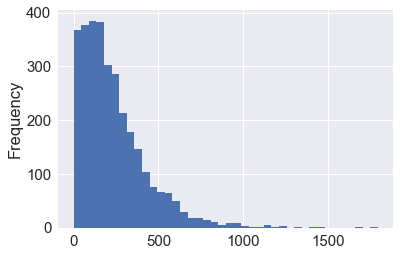

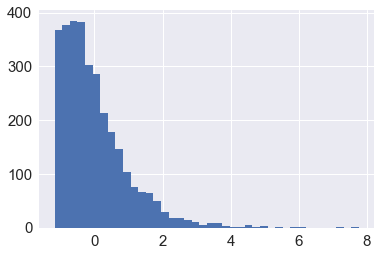

In [105]:
#### read crime rate
crime = pd.read_csv('crime_data_w_population_and_crime_rate.csv', 
                   usecols=[0, 1, 2, 21, 22, 23])
#create FIPS code by combining FIPSstate and FIPScity
crime['FIPStxt'] = pd.to_numeric(crime.FIPS_ST.apply(str)+
     crime.FIPS_CTY.apply(str).str.zfill(3))

crime['crime_rate_per_100000'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(crime['crime_rate_per_100000']), bins=40)
plt.show()
######

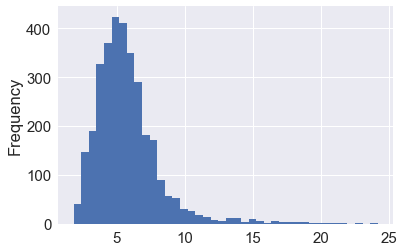

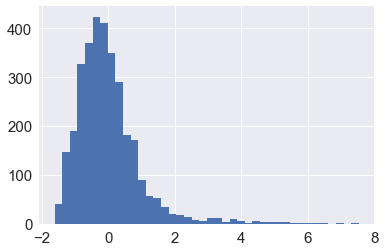

In [106]:
#### read 2015 unemployment rate and household income
#### No income data from PR
eco = pd.read_csv('Unemployment.csv',usecols=[0, 1, 2, 41, 46])
eco['Median_Household_Income_2015'] = eco['Median_Household_Income_2015'].str.replace(',','')
eco['Median_Household_Income_2015'] = pd.to_numeric(eco['Median_Household_Income_2015'])
eco['Median_Household_Income_2015'].fillna((eco['Median_Household_Income_2015'].mean()), inplace=True)
eco['Unemployment_rate_2015'].fillna((eco['Unemployment_rate_2015'].mean()), inplace=True)
eco['Unemployment_rate_2015'].plot.hist(bins=40)
plt.show()
plt.hist(preprocessing.scale(eco['Unemployment_rate_2015']), bins=40)
plt.show()
######

In [107]:
####containing 2015 Estimated percent of people of all ages
poverty = pd.read_csv('PovertyEstimates.csv',usecols=[0, 11])
#missing value'
poverty.rename(index=str, columns={'CI90LBALLP_2015':'poverty_rate'}, inplace=True)
poverty.ix[561,['poverty_rate']]=  0 
poverty['poverty_rate'] = pd.to_numeric(poverty['poverty_rate'])
#set missing value by median
poverty['poverty_rate'].fillna((poverty['poverty_rate'].mean()), inplace=True)
####

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



In [108]:

###Sources: Census Bureau,2011-2015 American Community Survey 5-yr average.
edu = pd.read_csv('Education.csv',usecols=[0, 45])
edu.rename(index=str, columns={'Percent of adults completing some college or associate\'s degree, 2011-2015':'college_rate'}, inplace=True)
edu['college_rate'].fillna((edu['college_rate'].mean()), inplace=True)
####

(1499, 7)


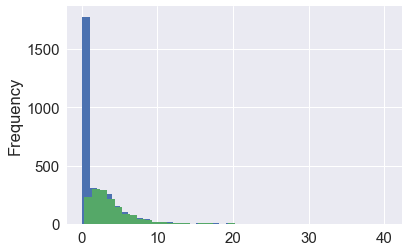

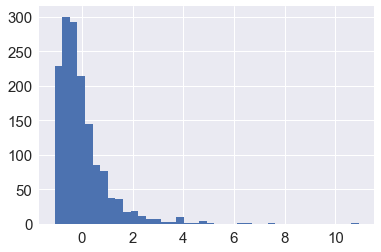

In [109]:
####cdc firearm death 1999-2015
fire = pd.read_csv('Underlying Cause of Death, 1999-2015.txt', 
                    delimiter='\t') 
fire['Deaths'] = pd.to_numeric(fire['Deaths'], errors='coerce')
fire['Population'] = pd.to_numeric(fire['Population'])
fire['fire_rate'] = 100000.0*fire['Deaths']/fire['Population']
#fill nan with 0
fire['fire_rate'] = fire['fire_rate'].fillna(value=0.0)
#round
fire['fire_rate'] = fire['fire_rate'].round(2)
fire['fire_rate'].plot.hist(bins=40)
fire = fire[fire.fire_rate != 0]
fire['fire_rate'].plot.hist(bins=40)
print fire.shape

plt.show()
plt.hist(preprocessing.scale(fire['fire_rate']), bins=40)
plt.show()
####

In [110]:
#normalize data
laws['curved_score'] = preprocessing.minmax_scale(laws['curved_score'])
eco['Unemployment_rate_2015'] = preprocessing.minmax_scale(eco['Unemployment_rate_2015'])
eco['Median_Household_Income_2015'] = preprocessing.minmax_scale(eco['Median_Household_Income_2015'])
crime['crime_rate_per_100000'] = preprocessing.minmax_scale(crime['crime_rate_per_100000'])
poverty['poverty_rate'] = preprocessing.minmax_scale(poverty['poverty_rate'])
edu['college_rate'] = preprocessing.minmax_scale(edu['college_rate'])
fire['fire_rate']  = preprocessing.minmax_scale(fire['fire_rate'] )

## merge to one dataframe
allData = pd.merge(eco, poverty, on='FIPStxt')
allData = pd.merge(allData, edu, left_on='FIPStxt', right_on='FIPS Code')
allData = pd.merge(allData, crime, on='FIPStxt')
allData = pd.merge(allData, fire, left_on='FIPStxt', right_on='County Code')
allData = pd.merge(allData, laws, left_on='State', right_on='code')
#allData = pd.merge(allData, crime, on='FIPStxt')
#allData FIPStxt code padding (add zero)
allData['FIPStxt'] = allData.FIPStxt.apply(str).str.zfill(5)

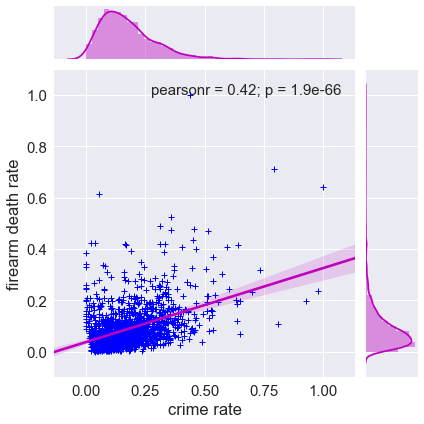

In [112]:
#a correlation between the two
g = sns.jointplot(x='crime_rate_per_100000', y='fire_rate', data=allData, kind="reg", color="m");
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels('crime rate', 'firearm death rate');
sns.set(font_scale=1.5)

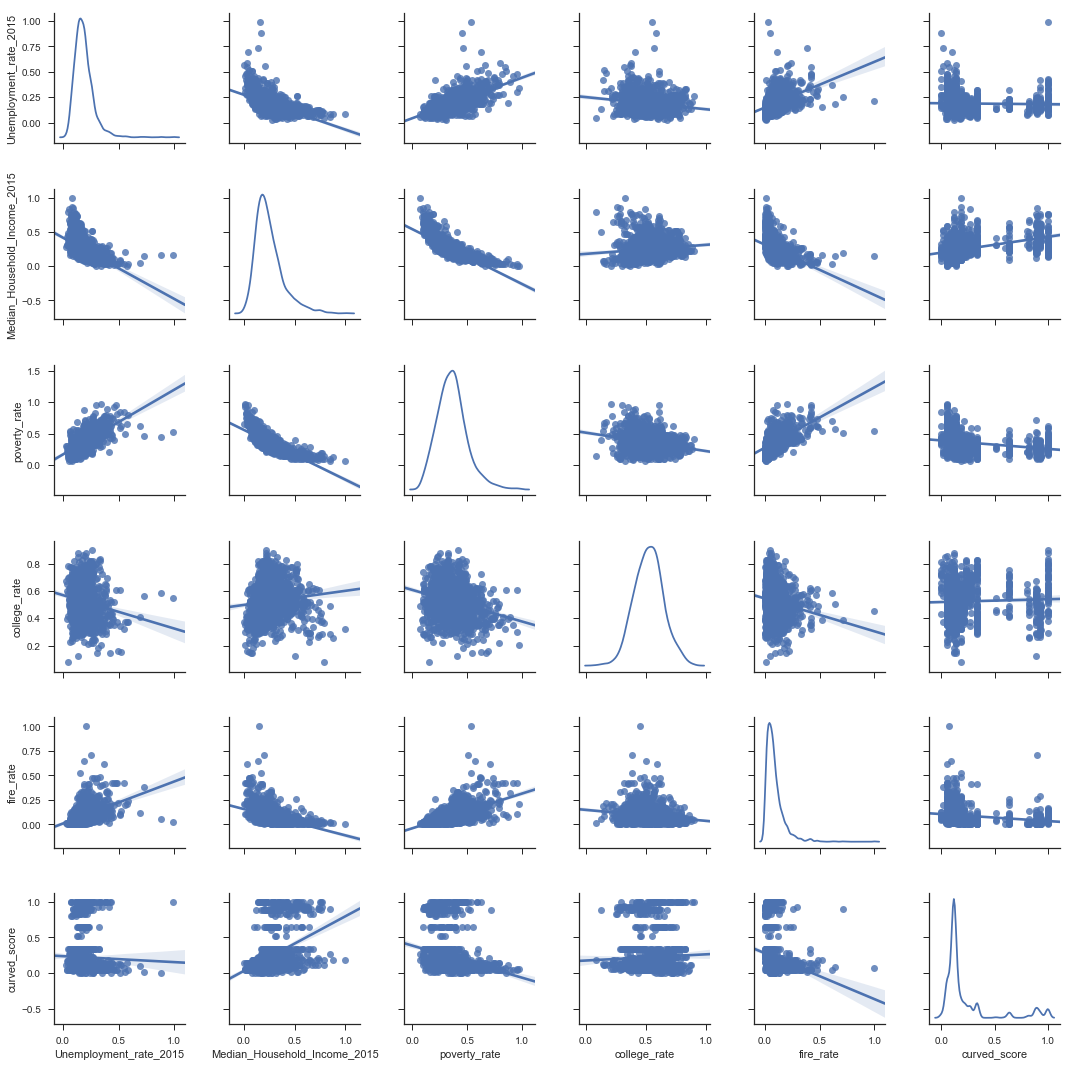

In [113]:

#plot scatter, correlation 
sns.set(style="ticks")
#sns.pairplot(allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
 #                     'poverty_rate','college_rate','fire_rate','curved_score']], diag_kind="kde", kind="reg")
sns.pairplot(allData[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','fire_rate','curved_score']], diag_kind="kde", kind="reg")
plt.savefig('scatermatrix.eps', format='eps', dpi=600)
plt.show()

In [114]:
#write to file
allData.to_csv('allData.csv')
print allData.shape
allData.head(5)

(1496, 24)


,FIPStxt,State,Area_name,Unemployment_rate_2015,Median_Household_Income_2015,poverty_rate,FIPS Code,college_rate,county_name,crime_rate_per_100000,...,Unnamed: 0,County,County Code,Deaths,Population,Crude Rate,fire_rate,code,state,curved_score
0,01001,AL,"Autauga County, AL",0.156250,0.327029,0.252451,1001,0.549223,"Autauga County, AL",0.140403,...,NaN,"Autauga County, AL",1001,23.0,864759,2.7,0.058073,AL,Alabama,0.138554
1,01003,AL,"Baldwin County, AL",0.169643,0.286323,0.264706,1003,0.585492,"Baldwin County, AL",0.127281,...,NaN,"Baldwin County, AL",1003,68.0,2895650,2.3,0.050313,AL,Alabama,0.138554
2,01005,AL,"Barbour County, AL",0.312500,0.082898,0.664216,1005,0.443005,"Barbour County, AL",0.098928,...,NaN,"Barbour County, AL",1005,26.0,473640,5.5,0.128911,AL,Alabama,0.138554
3,01007,AL,"Bibb County, AL",0.218750,0.173514,0.431373,1007,0.484456,"Bibb County, AL",0.121463,...,NaN,"Bibb County, AL",1007,24.0,374837,6.4,0.151690,AL,Alabama,0.138554
4,01009,AL,"Blount County, AL",0.160714,0.267878,0.291667,1009,0.595855,"Blount County, AL",0.117640,...,NaN,"Blount County, AL",1009,35.0,940072,3.7,0.084606,AL,Alabama,0.138554


In [115]:
##Do clustering 

##PCA first
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA

In [116]:
#data_cluster = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000','poverty_rate','college_rate']]
data_cluster = allData[['Unemployment_rate_2015','Median_Household_Income_2015','poverty_rate','college_rate']]
data_cluster.index = allData['Area_name']
data_cluster.head(5)

,Unemployment_rate_2015,Median_Household_Income_2015,poverty_rate,college_rate
Area_name,,,,
"Autauga County, AL",0.156250,0.327029,0.252451,0.549223
"Baldwin County, AL",0.169643,0.286323,0.264706,0.585492
"Barbour County, AL",0.312500,0.082898,0.664216,0.443005
"Bibb County, AL",0.218750,0.173514,0.431373,0.484456
"Blount County, AL",0.160714,0.267878,0.291667,0.595855


In [117]:
pca = PCA(n_components=2)
pca.fit(data_cluster)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [118]:
data_cluster_2d = pca.transform(data_cluster)
data_cluster_2d = pd.DataFrame(data_cluster_2d)
data_cluster_2d.index = data_cluster.index
data_cluster_2d.columns = ['PC1','PC2']
data_cluster_2d.head()

,PC1,PC2
Area_name,,
"Autauga County, AL",-0.137947,-0.001230
"Baldwin County, AL",-0.106553,-0.047390
"Barbour County, AL",0.364151,0.021791
"Bibb County, AL",0.113089,0.014830
"Blount County, AL",-0.081507,-0.062719


In [119]:
print(pca.explained_variance_ratio_) 

[ 0.63873539  0.23631035]


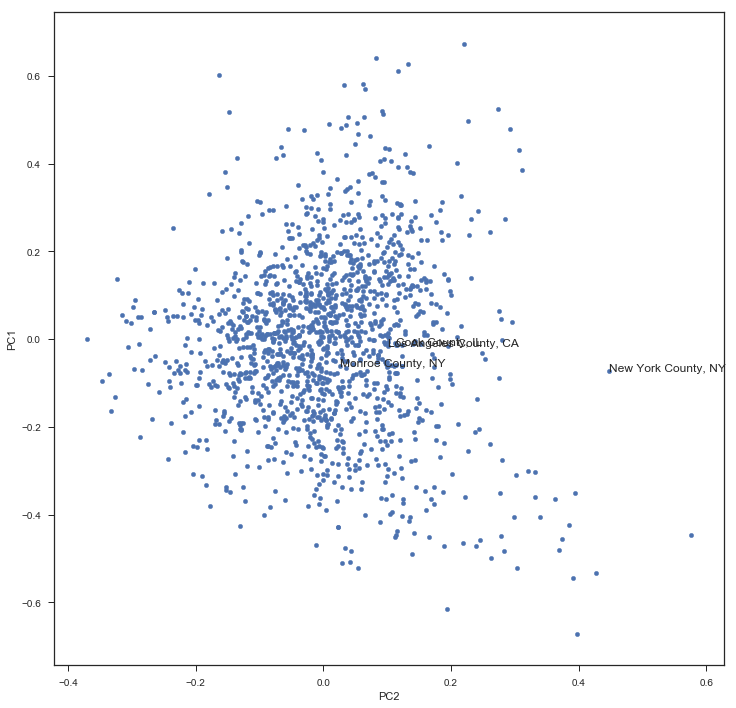

In [120]:
from random import *
countyPool = ['Los Angeles County, CA', 'San Francisco County, CA', 'Cook County, IL', 'Monroe County, NY', 'New York County, NY']
ax = data_cluster_2d.plot(kind='scatter', x='PC2', y='PC1', figsize=(12,12))

for i, country in enumerate(data_cluster_2d.index):
    if country in countyPool:
        ax.annotate(country, (data_cluster_2d.iloc[i].PC2, data_cluster_2d.iloc[i].PC1))

In [121]:
from sklearn.cluster import KMeans
n_clusters=6
kmeans = KMeans(n_clusters,random_state=25)
clusters = kmeans.fit(data_cluster_2d)

data_cluster_2d['cluster'] = pd.Series(clusters.labels_, index=data_cluster_2d.index)
#data_cluster_2d.head(10)
data_cluster_2d.to_csv('all_PCA_cluster.csv')

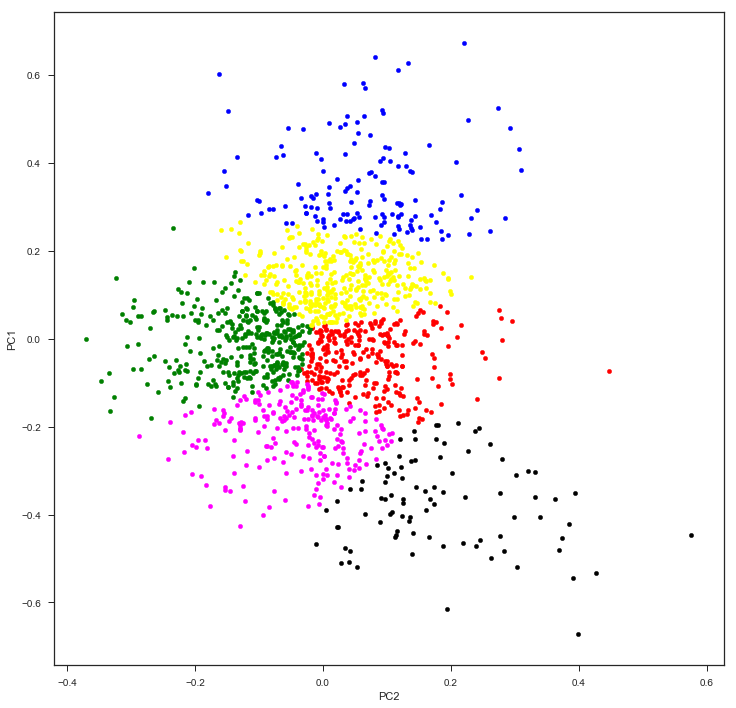

In [122]:
colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'yellow', 5:'magenta', 6:'orange', 7:'olive', 8:'olive'}
#data_cluster_2d['color'] = data_cluster_2d['cluster'].apply(lambda x: colors[x])
axk =data_cluster_2d.loc[data_cluster_2d['cluster']==0].plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=colors[0],
        figsize=(8,8))

for i in range(1, n_clusters):
    axk =data_cluster_2d.loc[data_cluster_2d['cluster']==i].plot(
        kind='scatter',
        x='PC2',y='PC1',
        c=colors[i],
        figsize=(12,12),
        ax = axk)


/Users/Xin/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning:

Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.



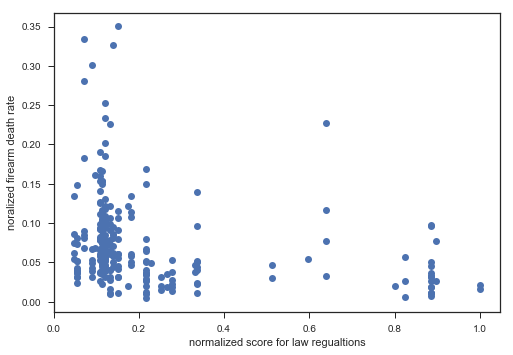

In [123]:
###since there seems to be only one cluster, try to use knn. The idea is intiliz a point, then find n neighors, then we can obeser
#the the associations between two variables.
#didn't use PCA here
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
X = data_cluster
n_neighbors=250
train_size = 4*n_neighbors/5
neigh = NearestNeighbors(n_neighbors)
neigh.fit(X) 

#give a county, find nearest index
inputVector = data_cluster.loc['Monroe County, NY'].values
distances, indices = neigh.kneighbors(inputVector)
#store fire_rate and score in a matrix
fireLaw = np.zeros((2,n_neighbors))
i = 0
for index in indices:
    for index_ in index:
       # allData.iloc[index_]['neighbor']  = 1
        fireLaw[0,i] = allData.iloc[index_]['curved_score']
        fireLaw[1,i] = allData.iloc[index_]['fire_rate']
        i += 1
smallData = pd.DataFrame(data=fireLaw[0,:])
smallData.columns = ['curved_score']
smallData['fire_rate'] = fireLaw[1,:]
smallData=smallData.sort_values(by=['curved_score'])
plt.plot(smallData['curved_score'], smallData['fire_rate'],'o')
plt.xlabel('normalized score for law regualtions')
plt.ylabel('noralized firearm death rate')

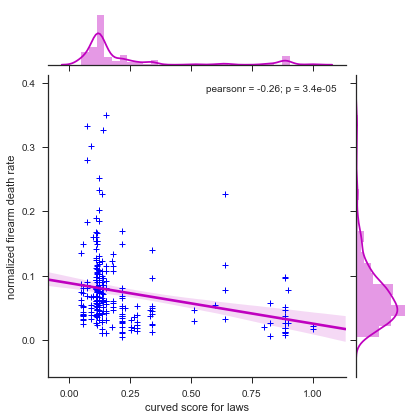

In [124]:
#a correlation between the two
g = sns.jointplot(x='curved_score', y='fire_rate', data=smallData[['curved_score','fire_rate']], kind="reg", color="m");
g.plot_joint(plt.scatter, c="b", s=30, linewidth=1, marker="+")
g.ax_joint.collections[0].set_alpha(0)
g.set_axis_labels("curved score for laws", "normalized firearm death rate");
sns.set(font_scale=1.5)

In [125]:
#Do a multilayer regression, trained only by fire_rate and law
#results very bad
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

nn = MLPRegressor(hidden_layer_sizes=(100,100), activation='relu')
X = fireLaw[0,:].reshape((n_neighbors,1))
y = fireLaw[1,:].reshape((n_neighbors,1))
kf = KFold(10)
scores = cross_val_score(nn, X, y, cv=10, scoring='neg_mean_absolute_error')
print -scores.mean()
nn.fit(trainData, trainData)

0.0794844511716


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

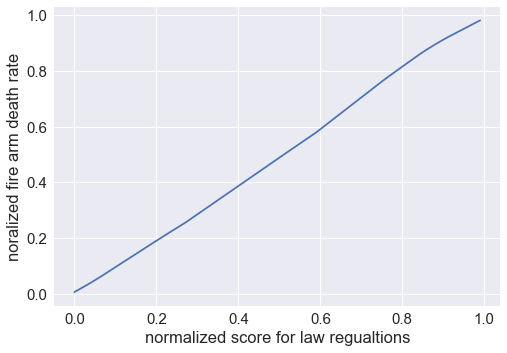

In [126]:
score = np.arange(0,1,0.01)
fire_predict = np.zeros(len(score))
for i in range(len(score)):
    fire_predict[i] = nn.predict((score[i]))

plt.plot(score, fire_predict)
plt.xlabel('normalized score for law regualtions')
plt.ylabel('noralized fire arm death rate')

Coefficients: 
[[-0.05939085]]
Mean squared error: 0.00
Variance score: 0.05


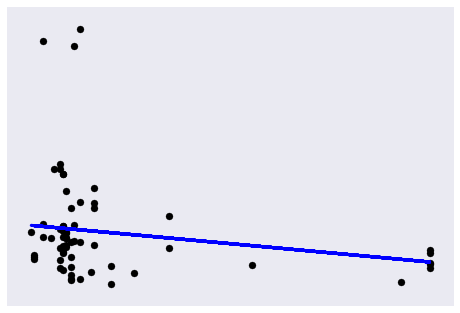

In [127]:
### do a linear regression for fire_rate and law
X = fireLaw[0,:].reshape((n_neighbors,1))
y = fireLaw[1,:].reshape((n_neighbors,1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)
# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print 'Coefficients: \n', regr.coef_
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [128]:
##multi layer perceptron regression 

In [222]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

nn = MLPRegressor(hidden_layer_sizes=(100,100), activation='relu')
#trainData = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
#                      'poverty_rate','college_rate','curved_score']].values

X = allData[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values
y = allData['fire_rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

#select 
X_fips = allData.index.values
y_fips = allData.index.values
X_fips_train, X_fips_test, y_fips_train, y_fips_test = train_test_split(X_fips, y_fips, test_size=0.2, random_state=45)
testData = allData.iloc[X_fips_test]

#select 

kf = KFold(10)
scores = cross_val_score(nn, X, y, cv=10, scoring='neg_mean_absolute_error')
print -scores.mean()
nn.fit(X_train, y_train)

0.0426622548383


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

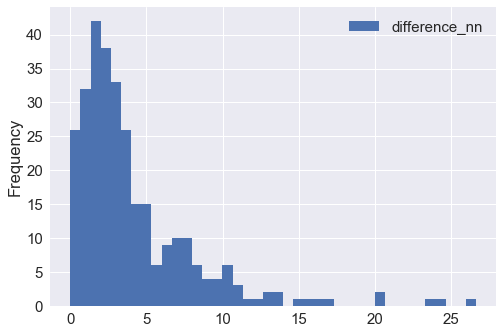

In [223]:
testData['predict_nn'] = nn.predict((testData[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
testData['difference_nn'] = 100*(testData['fire_rate'] - testData['predict_nn'])
testData['difference_nn'] = testData['difference_nn'].abs()
#print testData[['Area_name','difference_nn']].head(20)
testData[['difference_nn']].plot.hist(bins=40)

In [224]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [225]:
#trainData = allData[['Unemployment_rate_2015','Median_Household_Income_2015','crime_rate_per_100000',
#                      'poverty_rate','college_rate','curved_score']].values

X = allData[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values
y = allData['fire_rate'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)


regr = RandomForestRegressor()
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [226]:
print(regr.feature_importances_)
kf = KFold(10)
scores = cross_val_score(regr, X, y, cv=10, scoring='neg_mean_absolute_error')
print -scores.mean()

[ 0.18984424  0.35018918  0.45996658  0.          0.        ]
0.0500651022916


/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Xin/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

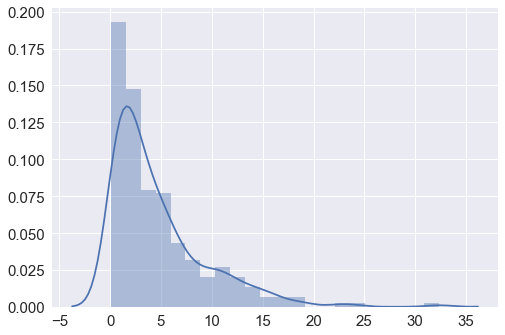

In [227]:
#Crude rate used to store RF precdition
testData['predict_rf'] = regr.predict(testData[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values)
testData['difference_rf'] = 100*(testData['fire_rate'] - testData['predict_rf'])
testData['difference_rf'] = testData['difference_rf'].abs()
g = sns.distplot(testData[['difference_rf']])
#g.set_axis_labels("density", "prediction accuracy");

In [228]:
#store ground truth and 
testData.to_csv('testData.csv')

[(0, 40)]

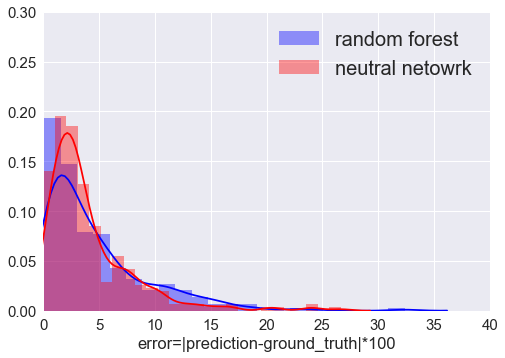

In [229]:
g = sns.distplot(testData[['difference_rf']], color="blue", label="random forest",axlabel = 'error=|prediction-ground_truth|*100')
sns.distplot(testData[['difference_nn']], color="red", label="neutral netowrk")
sns.plt.legend(fontsize=20)
g.set(ylim=(0, 0.3))
g.set(xlim=(0, 40))

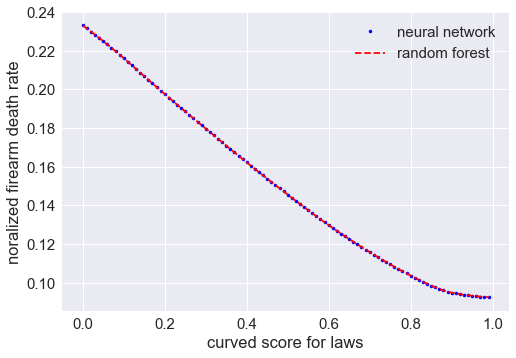

In [230]:
#### insert all data and law scores, check law score and crime rate relation
testData2 = allData

score = np.arange(0,1,0.01)
fire_predict_nn = np.zeros(len(score))
fire_predict_rf = np.zeros(len(score))
for i in range(len(score)):
    testData2['curved_score'] = score[i]
    testData2['predict_nn'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    testData2['predict_rf'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    fire_predict_nn[i] = testData2['predict_nn'].mean()
    fire_predict_rf[i] = testData2['predict_rf'].mean()


plt.plot(score, fire_predict_nn, 'b.')
plt.plot(score, fire_predict_rf, 'r--')
plt.xlabel('curved score for laws')
plt.ylabel('noralized firearm death rate')
plt.legend(['neural network','random forest'], loc='upper right')
plt.show()

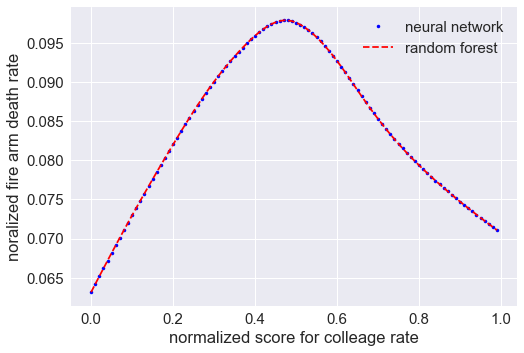

In [158]:
#### insert all data and law scores, check education and crime rate relation
testData2 = allData

score = np.arange(0,1,0.01)
fire_predict_nn = np.zeros(len(score))
fire_predict_rf = np.zeros(len(score))
for i in range(len(score)):
    testData2['college_rate'] = score[i]
    testData2['predict_nn'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    testData2['predict_rf'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    fire_predict_nn[i] = testData2['predict_nn'].mean()
    fire_predict_rf[i] = testData2['predict_rf'].mean()


plt.plot(score, fire_predict_nn, 'b.')
plt.plot(score, fire_predict_rf, 'r--')
plt.xlabel('normalized score for colleage rate')
plt.ylabel('noralized fire arm death rate')
plt.legend(['neural network','random forest'], loc='upper right')
plt.show()

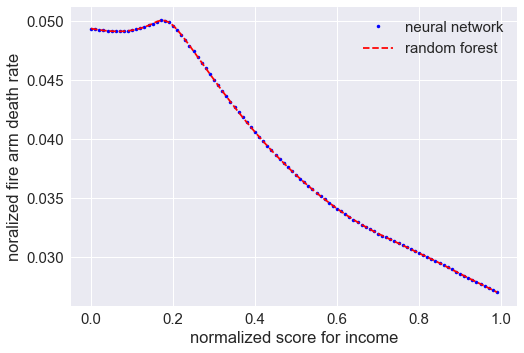

In [66]:
#### insert all data and law scores, check income and crime rate relation
testData2 = allData

score = np.arange(0,1,0.01)
fire_predict_nn = np.zeros(len(score))
fire_predict_rf = np.zeros(len(score))
for i in range(len(score)):
    testData2['Median_Household_Income_2015'] = score[i]
    testData2['predict_nn'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    testData2['predict_rf'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    fire_predict_nn[i] = testData2['predict_nn'].mean()
    fire_predict_rf[i] = testData2['predict_rf'].mean()


plt.plot(score, fire_predict_nn, 'b.')
plt.plot(score, fire_predict_rf, 'r--')
plt.xlabel('normalized score for income')
plt.ylabel('noralized fire arm death rate')
plt.legend(['neural network','random forest'], loc='upper right')
plt.show()

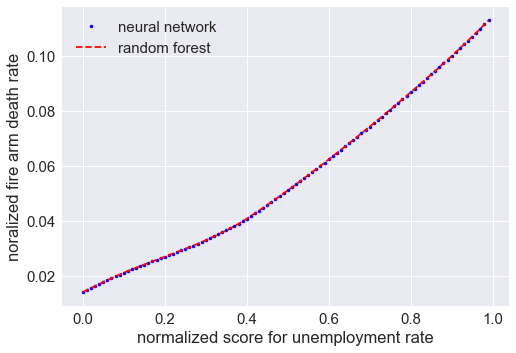

In [70]:
#### insert all data and law scores, check unemployment rate and crime rate relation
testData2 = allData

score = np.arange(0,1,0.01)
fire_predict_nn = np.zeros(len(score))
fire_predict_rf = np.zeros(len(score))
for i in range(len(score)):
    testData2['Unemployment_rate_2015'] = score[i]
    testData2['predict_nn'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    testData2['predict_rf'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    fire_predict_nn[i] = testData2['predict_nn'].mean()
    fire_predict_rf[i] = testData2['predict_rf'].mean()


plt.plot(score, fire_predict_nn, 'b.')
plt.plot(score, fire_predict_rf, 'r--')
plt.xlabel('normalized score for unemployment rate')
plt.ylabel('noralized fire arm death rate')
plt.legend(['neural network','random forest'], loc='upper left')
plt.show()

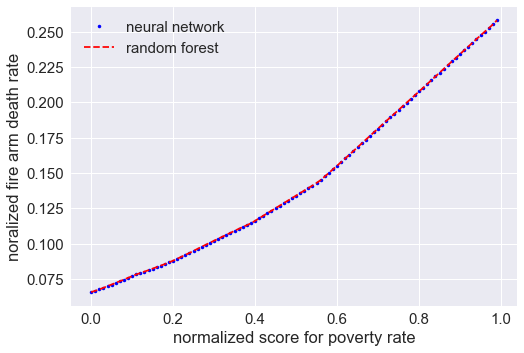

In [72]:
#### insert all data and law scores, check unemployment rate and crime rate relation
testData2 = allData

score = np.arange(0,1,0.01)
fire_predict_nn = np.zeros(len(score))
fire_predict_rf = np.zeros(len(score))
for i in range(len(score)):
    testData2['poverty_rate'] = score[i]
    testData2['predict_nn'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    testData2['predict_rf'] = nn.predict((testData2[['Unemployment_rate_2015','Median_Household_Income_2015',
                      'poverty_rate','college_rate','curved_score']].values))
    fire_predict_nn[i] = testData2['predict_nn'].mean()
    fire_predict_rf[i] = testData2['predict_rf'].mean()


plt.plot(score, fire_predict_nn, 'b.')
plt.plot(score, fire_predict_rf, 'r--')
plt.xlabel('normalized score for poverty rate')
plt.ylabel('noralized fire arm death rate')
plt.legend(['neural network','random forest'], loc='upper left')
plt.show()